# Рекомендация тарифов

Заказчик исследования - оператор мобильной связи "Мегалайн". Оператор выяснил, что многие клиенты пользуются архивными тарифами, однако они хотели бы предложить им выбор из двух существующих: "Смарт" или "Ультра". Входные данные от компании -  данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Результаты исследования будут использованы заказчиком в коммерческих целях.

**Цель исследования**: построить модель, которая будет выбирать пользователю подходящий тариф

Ход исследования:

Входные данные от компании - статистика поведения пользователей за месяц. Данные прошли предварительную обработку данных, поэтому преодобработка не потребуется. Изучим данные и акцентируем внимание на построение качественной модели для классификации. Для выбора такой модели придется разбить данные на выборки, после чего исследовать различные варианты моделей. После этого проверим модель на тестовой выборке и, наконец, проверим её на адекватность.

Таким образом, исследование пройдёт в 5 этапов:

* 1. Изучение данных из файла.
* 2. Разбиение данных на выборки.
* 3. Исследование моделей.
* 4. Проверка модели на тестовой выборке.
* 5. Проверка модели на адекватность.


## Изучение данных из файла

Перед тем, как приступить к изучению данных из файла, импортируем все нужные для текущего исследования библиотеки и модули:

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Прочитаем полученные данные и сохраним их в таблице `df`, после чего выведем на экран первые 5 строк:

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Получим общую информацию о таблице:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице имеется 3214 строк и 5 столбцов. 4 из этих столбцов имеют тип `float`, 1 - `int`. Как нам известно, данные уже обработаны и в их качестве в текущем исследовании можно не сомневаться, значит, предобработка не потребуется. Согласно документации к данным:

* `сalls` — количество звонков;
* `minutes` — суммарная длительность звонков в минутах;
* `messages` — количество sms-сообщений;
* `mb_used` — израсходованный интернет-трафик в Мб;
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим на корреляции в данных и их распределения. Для этого применим специальный метод библиотеки `seaborn`:

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


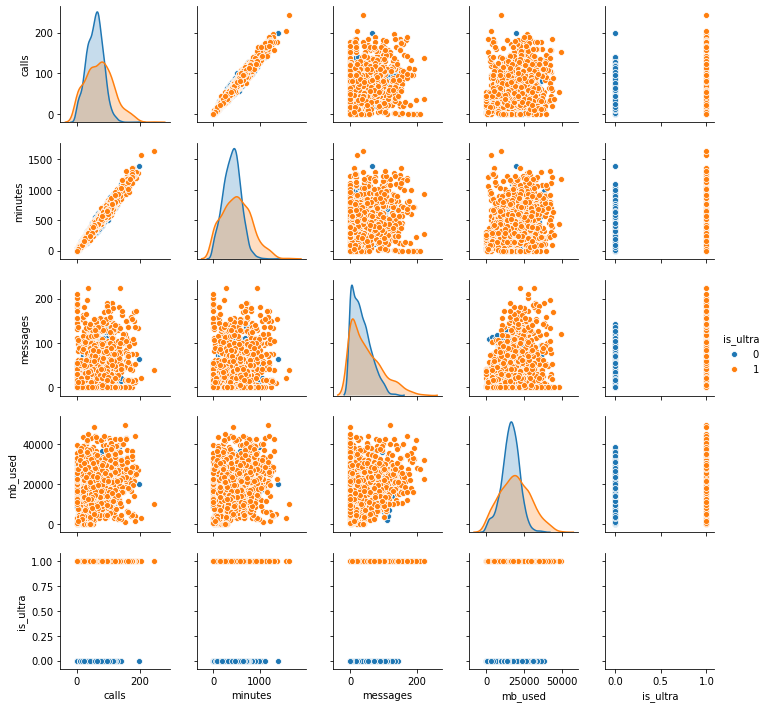

In [4]:
sns.pairplot(df, hue='is_ultra', height=2)

Видно, что пользователи различных тарифов отличаются своим поведением. Пользователи "Ультра" в среднем используют свои пакеты услуг в большей степени, и это логично, ведь сам тариф подразмевает это. Видна сильная зависимость между количеством звонов и их продолжительностью. Это говорит о том, что средние продолжительности звонков у пользователей стремятся к некоторому единому среднему, а выбросов, где пользователь совершает 100 звонков, но их продолжительность в сумме даёт 4 минуты, нет. 

### Вывод

В таблице имеются данные по 3214 пользователям "Мегалайна". Для каждого из них представлена месячная статистика основных параметров тарифов: количество звонков, их длительность, количество отправленных сообщений, использованный трафик и их тариф ("Смарт" или "Ультра). Можно утверждать, что выборка достаточна для построения качественной модели классификации. Поведение пользователей двух тарифов отличается, что демонстрируют построенные графики. Предобработка данных не потребуется, поэтому можем переходить к разбиению данных на выборки.

## Разбиение данных на выборки

Перед разбиением данных на выборки необходимо организовать 2 переменные, где в первой будут храниться наши признаки, а во второй - целевой признак:

In [5]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Теперь данные необходимо разбить на 3 выборки: обучающую, валидационную и тестовую. Для этого используем стандартные правила разбиения для такого случая: пропорцию 3:1:1:

In [6]:
#разбиваем features и target на три выборки в пропорции 60%:20%:20% и заданным случайное значение 28 тут и далее
RANDOM_STATE = 28
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=RANDOM_STATE)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                              test_size=0.2, random_state=RANDOM_STATE)

### Вывод

Мы разбили наши данные на 3 выборки: обучающую, валидационную и тестовую в пропорции 3:1:1. Данные выборки потребуются нам для обучения модели и её проверках. Теперь необходимо исследовать различные модели классификации, чтобы далее выбрать наиболее оптимальную под исследование.

## Исследование моделей

Нам предстоит выбрать подходящую модель классификации из трёх вариантов: дерево решений, лес решений, логистическая регрессия. Начнём построение моделей с дерева решений. Для этого воспользуемся специальным модулем библиотеки `sklearn`. Чтобы понять, какая глубина будет для дерева оптимальной, применим цикл:

In [7]:
#зададим нулевые гиперпараметры для лучшей модели, максимальной глубины дерева и лучшего accuracy_score
best_model_tree = None
best_depth_tree = 0
best_result_tree = 0
#с помощью цикла переберём модели по глубине дерева и выявим наилучшую по accuracy_score
for depth in range(1, 5):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    #наилучшую модель сохраняем
    if result > best_result_tree:
        best_model_tree = model
        best_depth_tree = depth
        best_result_tree = result
print('Наилучшее дерево решений имеет глубину:', best_depth_tree, "и её accuracy составляет:", best_result_tree)

Наилучшее дерево решений имеет глубину: 3 и её accuracy составляет: 0.80248833592535


У нас имелось 4 признака, но наилучшее дерево решений применяет лишь 3 из них. Вероятно, один из факторов является для него незначимым. `Accuracy_score` равен чуть более 0.8, что является хорошим показателем для модели, однако выводы делать рано - далее построим модель леса решений. 

In [8]:
#зададим нулевые гиперпараметры для лучшей модели, максимальной глубины каждого дерева, критерия, количества деревьев и accuracy
best_model_forest = None
best_depth_forest = 0
best_result_forest = 0
best_est_forest = 0
best_criterion_forest = None
#с помощью вложенного цикла переберём различные гиперпараметры и выявим наилучшую модель по accuracy
for crit in ['gini', 'entropy']:
    for est in range(1, 30):
        for depth in range(1, 5):
            model = RandomForestClassifier(random_state=RANDOM_STATE, criterion=crit,
                                          max_depth=depth, n_estimators=est)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            #наилучшую модель сохраняем
            if result > best_result_forest:
                best_model_forest = model
                best_depth_forest = depth
                best_result_forest = result
                best_est_forest = est
                best_criterion_forest = crit
print('Наилучший лес решений имеет глубину:', best_depth_forest,',', 'критерий:', best_criterion_forest,',', 'число деревьев:',
     best_est_forest, 'и его accuracy составляет:', best_result_forest)

Наилучший лес решений имеет глубину: 4 , критерий: gini , число деревьев: 22 и его accuracy составляет: 0.8149300155520995


Получили, что для леса решений максимальная глубина каждого дерева 4, деревьев 22 и критерий используется Джини. При этом, `accuracy_score` у леса оказывается выше, чем у дерева решений: 0.814. Остаётся проверить только модель логистической регрессии:

In [9]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print('Модель логистической регрессии имеет accuracy_score:', result)

Модель логистической регрессии имеет accuracy_score: 0.7200622083981337


### Вывод

Таким образом, получили три различных модели и их `accuracy_score`. Наихудший показатель представлен у модели логистической регрессии - 0.72. Далее по возрастанию идёт модель дерева решений с показателем в 0.8, но наилучший результат был достигнут у леса решений, и он составил 0.814. Возможно, это связано с тем, что именно дереву решений было дано больший разброс в гиперпараметрах для подбора качественной модели. Далее нужно модель леса решений проверить на тестовой выборке и убедиться, что она адекватна.

## Проверка модели на тестовой выборке

Возьмём наш лес решений с наиболее оптимальными параметрами, которые нам уже известны, и проверим модель на тестовой выборке:

In [10]:
model = RandomForestClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=4, n_estimators=3)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print('Accuracy случайного леса на тестовой выборке составил:', result)

Accuracy случайного леса на тестовой выборке составил: 0.8038834951456311


### Вывод

`Accuracy_score` леса решений на тестовой выборке составил 0.803, что чуть ниже, чем на валидационной выборке. Следовательно, наша модель успешно прошла все тесты и может использоваться для предсказания лучшего тарифа для пользователя. Мы не выявили у неё ни переобучения, ни недоучения. Однако, дополнительно мы можем в завершении проверить модель на адекватность.

## Проверка модели на адекватность

Чтобы проверить модель на адекватность, сравним её `accuracy_score` со случайной моделью:

In [11]:
model = RandomForestClassifier()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print('Accuracy случайной модели на тестовой выборке составил:', result)

Accuracy случайной модели на тестовой выборке составил: 0.8


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Вывод

`Accuracy_score` в нашей модели леса решений при проверке на тестовой выборке составил 0.803, когда случайная модель даёт значение 0.782. В целом, это хорошие качественные результаты, поэтому можем говорить об адекватности выбранной модели.

## Вывод

В исследовании было необходимо построить модель, которая сможет выбирать пользователям подходящий тариф "Смарт" или "Ультра". Для этого было решено проверить три модели:

* Дерево решений - accuracy 0.802
* Лес решений - accuracy 0.814
* Логистическая регрессия - accuracy 0.72

Таким образом, для дальнейших тестов был выбран лес решений, который показал хорошие результаты на тестовой выборке. В данном случае accuracy составил 0.803. Также модель прошла проверка на адекватность, доказав своё превосходство перед случайной моделью. Компания "Мегалайн" может спокойно использовать лес решений и получать минимальное количество ошибок при выборке для пользователя подходящего тарифа.